In [1]:
import sympy as sp
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
%matplotlib inline

In [3]:
# Weights
w_c, w_l, w_s = sp.symbols('w_c w_l w_s', positive=True)
# Token balances
x_c, x_l, x_s = sp.symbols('x_c x_l x_s', positive=True)
# Prices - in units of locked up collateral
v = sp.symbols('v', positive=True) 
# Swap fee in fraction of input tokens
s_f = sp.symbols('s_f')
# Decimal scaling 
d_c, d_p = sp.symbols('d_c d_p', positive=True)
# Collateral backing L + S 
# e.g. for $100.000_000_000_000_000_000 = 1.000_000 mt
# this is 100*10**18 / 1*10**6 = 10**14
C = sp.symbols('C', positive=True)

In [4]:
def calc_spot_price(bI, wI, bO, wO, sF=0):
    """
    calcSpotPrice                                                                             //
     sP = spotPrice                                                                            //
     bI = tokenBalanceIn                ( bI / wI )         1                                  //
     bO = tokenBalanceOut         sP =  -----------  *  ----------                             //
     wI = tokenWeightIn                 ( bO / wO )     ( 1 - sF )                             //
     wO = tokenWeightOut                                                                       //
     sF = swapFee 
    """
    return (bI/wI)/(bO/wO)/(1-sF)

In [5]:
# e.g. condition for spot price of long token without fees to be v*C
calc_spot_price(x_c, w_c, x_l, w_l) - v*C

-C*v + w_l*x_c/(w_c*x_l)

In [6]:
sol = sp.solve(
    [w_c + w_l + w_s - 1,   # Weights sum to 1
     calc_spot_price(x_c, w_c, x_l, w_l, 0) - v*C,      # Long token price = v*C
     calc_spot_price(x_c, w_c, x_s, w_s, 0) - (1-v)*C,  # Short token price = (1-v)*C
    ]
     , [w_c, w_l, w_s])

In [7]:
sol[w_c]

x_c/(C*v*x_l - C*x_s*(v - 1) + x_c)

In [8]:
sol[w_l]

C*v*x_l/(C*v*x_l - C*x_s*(v - 1) + x_c)

In [9]:
sol[w_s]

-C*x_s*(v - 1)/(C*v*x_l - C*x_s*(v - 1) + x_c)

In [10]:
# Full set of weights needed to set the spot prices of long and short tokens
sol

{w_c: x_c/(C*v*x_l - C*x_s*(v - 1) + x_c),
 w_l: C*v*x_l/(C*v*x_l - C*x_s*(v - 1) + x_c),
 w_s: -C*x_s*(v - 1)/(C*v*x_l - C*x_s*(v - 1) + x_c)}

In [11]:
# Check spot prices
calc_spot_price(x_c, w_c, x_l, w_l, s_f).subs(sol) # Long spot price

C*v/(1 - s_f)

In [12]:
calc_spot_price(x_c, w_c, x_s, w_s, s_f).subs(sol)

-C*(v - 1)/(1 - s_f)

In [13]:
def calc_out_given_in(bO, wO, bI, wI, aI, sF=0):
    """
    calcOutGivenIn                                                                            //
     aO = tokenAmountOut                                                                       //
     bO = tokenBalanceOut                                                                      //
     bI = tokenBalanceIn              /      /            bI             \    (wI / wO) \      //
     aI = tokenAmountIn    aO = bO * |  1 - | --------------------------  | ^            |     //
     wI = tokenWeightIn               \      \ ( bI + ( aI * ( 1 - sF )) /              /      //
     wO = tokenWeightOut                                                                       //
     sF = swapFee 
    """
    return bO*(1-(bI/(bI + (aI*(1-sF))))**(wI/wO))

In [14]:
def calc_in_given_out(bO, wO, bI, wI, aO, sF=0):
    """
    calcInGivenOut                                                                            //
     aI = tokenAmountIn                                                                        //
     bO = tokenBalanceOut               /  /     bO      \    (wO / wI)      \                 //
     bI = tokenBalanceIn          bI * |  | ------------  | ^            - 1  |                //
     aO = tokenAmountOut    aI =        \  \ ( bO - aO ) /                   /                 //
     wI = tokenWeightIn           --------------------------------------------                 //
     wO = tokenWeightOut                          ( 1 - sF )                                   //
     sF = swapFee                                               
    """
    return bI*((bO/(bO - aO))**(wO/wI) - 1)/(1-sF)

In [15]:
# Input token amounts for swaps
a_c, a_l, a_s = sp.symbols('a_c a_l a_s', positive=True)

In [16]:
n, d = sp.fraction(w_c.subs(sol))

In [17]:
w_c.subs(sol).subs({d: 1})

x_c

# Working with AMM State
We now look at the state of the AMM after performing operations such as swapping from C to L or vice versa.

In [47]:
def set_amm_state(x_c, x_l, x_s, v, C, sF=0):
    """For fixed token balances calculate the weights needed to achieve 
    L price = v*C, S price = (1-v)*C where C is the coin needed to mint 1 L + 1 S 
    """
    sol = sp.solve(
    [w_c + w_l + w_s - 1,   # Weights sum to 1
     calc_spot_price(x_c, w_c, x_l, w_l, sF) - v*C,      # Long token price = v*C
     calc_spot_price(x_c, w_c, x_s, w_s, sF) - (1-v)*C,  # Short token price = (1-v)*C
    ]
     , [w_c, w_l, w_s])
    return [x_c, x_l, x_s, sol[w_c], sol[w_l], sol[w_s]]

In [48]:
def get_amm_spot_prices(state, sF=0):
    """Return L and S prices in units of coin
    """
    coin_ind = 0
    ltk_ind = 1
    stk_ind = 2
    n_tok = len(state) // 2
    ltk_price, stk_price = (
        calc_spot_price(
            state[coin_ind], state[coin_ind + n_tok],
            state[tok_ind], state[tok_ind + n_tok],
            sF) for tok_ind in [ltk_ind, stk_ind]
    )
    return [ltk_price, stk_price]

In [49]:
# Check that we get the correct price 
get_amm_spot_prices(
    set_amm_state(
        10000,   # $10 000
        100,     # 100 L
        100,     # 100 S
        0.5, 100    # L price is 0.5*$100
    )
)

[50.0000000000000, 50.0000000000000]

In [50]:
# Note that we don't need to have the same number of tokens to achieve equal L and S price
# as the weights can achieve any price
get_amm_spot_prices(
    set_amm_state(
        10000,   # $10 000
        100,     # 100 L
        10,      # 10 S
        0.5, 100    # L price is 0.5*$100
    )
)

[50.0000000000000, 50.0000000000000]

## Trading - simple swaps 
Look at what happens when we trade with the pool without using the Mettalex vault to mint and redeem tokens.  We see arbitrage opportunities being created when L + S != C.

To avoid this arbitrage opportunity we can rebalance the pool after each swap so that L + S = C

In [51]:
def simple_swap_from_coin(state, aI, to_long=True, sF=0, coin_per_pair=1,
    rebalance=False, rebalance_fun=set_amm_state):
    """Swap a_c coins in for specified token (1=L, 2=S)
    """
    tok_ind = 1 if to_long else 2
    coin_ind = 0
    n_tok = len(state) // 2
    # calc_out_given_in(bO, wO, bI, wI, aI, sF=0)
    bO = state[tok_ind]
    wO = state[tok_ind + n_tok]
    bI = state[coin_ind]
    wI = state[coin_ind + n_tok]
    aO = calc_out_given_in(bO, wO, bI, wI, aI, sF)
    avg_price = aI / aO  # Price paid to AMM in coin for each position token
    if to_long:
        new_state = [
            state[0] + aI,
            state[1] - aO,
            state[2],
            state[3], state[4], state[5]
        ]
    else:
        new_state = [
            state[0] + aI,
            state[1],
            state[2] - aO,
            state[3], state[4], state[5]
        ]
    if rebalance:
        new_spot = get_amm_spot_prices(new_state)
        new_state = rebalance_fun(
            new_state[0], new_state[1], new_state[2],
            new_spot[0]/(new_spot[0] + new_spot[1]),
            coin_per_pair
        )
    
    return new_state, aO, avg_price

In [52]:
simple_swap_from_coin(set_amm_state(10000, 100, 100, 0.5, 100), 500)

([10500,
  90.7029478458050,
  100,
  0.500000000000000,
  0.250000000000000,
  0.250000000000000],
 9.29705215419502,
 53.7804878048780)

In [53]:
get_amm_spot_prices(simple_swap_from_coin(set_amm_state(10000, 100, 100, 0.5, 100), 500)[0])

[57.8812500000000, 52.5000000000000]

In [54]:
def simple_swap_to_coin(
    state, aI, from_long=True, sF=0,
    coin_per_pair=1, rebalance=False, rebalance_fun=set_amm_state):
    """Swap position tokens in for coin
    """
    tok_ind = 1 if from_long else 2
    coin_ind = 0
    n_tok = len(state) // 2
    # calc_out_given_in(bO, wO, bI, wI, aI, sF=0)
    bO = state[coin_ind]
    wO = state[coin_ind + n_tok]
    bI = state[tok_ind]
    wI = state[tok_ind + n_tok]
    aO = calc_out_given_in(bO, wO, bI, wI, aI, sF)
    avg_price = aO / aI  # Price in coin paid for input position token
    if from_long:
        new_state = [
            state[0] - aO,
            state[1] + aI,
            state[2],
            state[3], state[4], state[5]
        ]
    else:
        new_state = [
            state[0] - aO,
            state[1],
            state[2] + aI,
            state[3], state[4], state[5]
        ]
    if rebalance:
        new_spot = get_amm_spot_prices(new_state)
        new_state = rebalance_fun(
            new_state[0], new_state[1], new_state[2],
            new_spot[0]/(new_spot[0] + new_spot[1]),
            coin_per_pair
        )
    
    return new_state, aO, avg_price

In [55]:
simple_swap_to_coin(set_amm_state(10000, 100, 100, 0.5, 100), 1)

([9950.37190209989,
  101,
  100,
  0.500000000000000,
  0.250000000000000,
  0.250000000000000],
 49.6280979001085,
 49.6280979001085)

### Price impact for purchasing position tokens 

In [56]:
# Price impact for range of long token purchases
initial_state = set_amm_state(10000, 100, 100, 0.5, 100)
coin_in = np.linspace(1., 5000., 20)
states, tok_out, avg_price = zip(*[simple_swap_from_coin(initial_state, c) for c in coin_in])

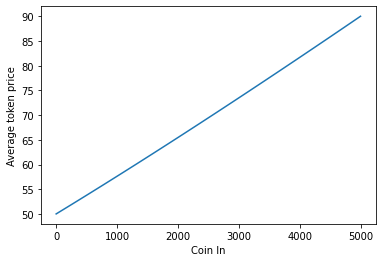

In [57]:
_ = plt.plot(coin_in, avg_price)
_ = plt.xlabel('Coin In')
_ = plt.ylabel('Average token price')

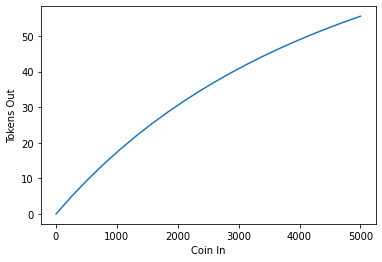

In [58]:
_ = plt.plot(coin_in, tok_out)
_ = plt.xlabel('Coin In')
_ = plt.ylabel('Tokens Out')

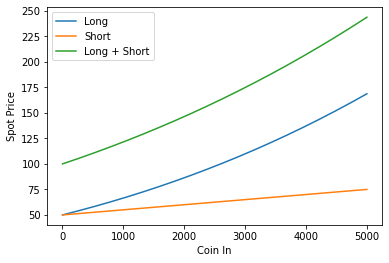

In [59]:
# Spot prices and sum
spot_prices = np.array([get_amm_spot_prices(s) for s in states])
_ = plt.plot(coin_in, spot_prices)
_ = plt.plot(coin_in, np.sum(spot_prices, axis=1))
_ = plt.legend(['Long', 'Short', 'Long + Short'])
_ = plt.xlabel('Coin In')
_ = plt.ylabel('Spot Price')

### Price impact for selling position tokens

In [60]:
initial_state = set_amm_state(10000, 100, 100, 0.5, 100)
tok_in = np.linspace(1., 50., 20)
states, coin_out, avg_price = zip(*[simple_swap_to_coin(initial_state, t) for t in tok_in])

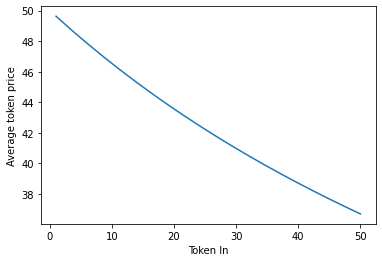

In [61]:
_ = plt.plot(tok_in, avg_price)
_ = plt.xlabel('Token In')
_ = plt.ylabel('Average token price')

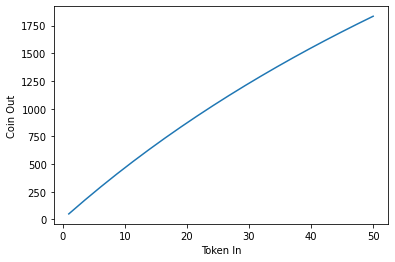

In [62]:
_ = plt.plot(tok_in, coin_out)
_ = plt.xlabel('Token In')
_ = plt.ylabel('Coin Out')

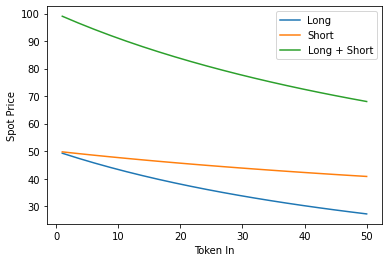

In [63]:
# Spot prices and sum
spot_prices = np.array([get_amm_spot_prices(s) for s in states])
_ = plt.plot(tok_in, spot_prices)
_ = plt.plot(tok_in, np.sum(spot_prices, axis=1))
_ = plt.legend(['Long', 'Short', 'Long + Short'])
_ = plt.xlabel('Token In')
_ = plt.ylabel('Spot Price')

# Pool balance
What is the value of the assets in the pool?  
* A conservative option is to count only coin and paired tokens in which case value is $x_c + \min(x_l, x_s)*C$.  
* A less conservative option uses the spot price of all assets in pool in which case value is $x_c + x_l*v_l*C + x_s*v_s*C$ where the current spot price fractions $v_p, v_s$ reflect the pool spot price taking into account position imbalances i.e. $v_p = \frac{x_c}{x_l}\frac{w_l}{w_c}/C$ etc.

Use the latter value function for the moment and see how we can rebalance the pool after swap to keep the value constant.

In [72]:
def get_amm_balance(state):
    spot_prices = get_amm_spot_prices(state)
    return state[0] + state[1]*spot_prices[0] + state[2]*spot_prices[1]

In [73]:
get_amm_balance(initial_state)

20000.0000000000

In [116]:
# Price impact for range of long token purchases
initial_state = set_amm_state(10000, 100, 100, 0.5, 100)
coin_in = np.linspace(1., 5000., 20)
# With reweighting of tokens to achieve sum pf prices equal to collateral
states, tok_out, avg_price = zip(
    *[simple_swap_from_coin(initial_state, c, coin_per_pair=100, rebalance=True) for c in coin_in])
# No rebalancing, raw C->L (or C->S) swap
states_raw, tok_out_raw, avg_price_raw = zip(
    *[simple_swap_from_coin(initial_state, c, coin_per_pair=100, rebalance=False) for c in coin_in])

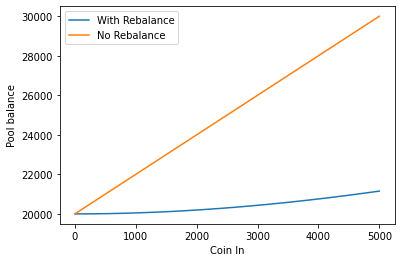

In [117]:
# Pool balance
balances = np.array([get_amm_balance(s) for s in states])
balances_raw = np.array([get_amm_balance(s) for s in states_raw])
_ = plt.plot(coin_in, balances)
_ = plt.plot(coin_in, balances_raw) # No rebalance
_ = plt.legend(['With Rebalance', 'No Rebalance'])
_ = plt.xlabel('Coin In')
_ = plt.ylabel('Pool balance')

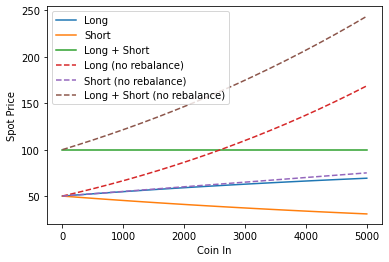

In [118]:
# Spot prices and sum
spot_prices = np.array([get_amm_spot_prices(s) for s in states])
spot_prices_raw = np.array([get_amm_spot_prices(s) for s in states_raw])

_ = plt.plot(coin_in, spot_prices)
_ = plt.plot(coin_in, np.sum(spot_prices, axis=1))
_ = plt.plot(coin_in, spot_prices_raw, linestyle='--')
_ = plt.plot(coin_in, np.sum(spot_prices_raw, axis=1), linestyle='--')
_ = plt.legend(['Long', 'Short', 'Long + Short', 
                'Long (no rebalance)', 'Short (no rebalance)', 'Long + Short (no rebalance)'])
_ = plt.xlabel('Coin In')
_ = plt.ylabel('Spot Price')

# Swap scenarios
Testing different options to swap coin for position tokens and vice versa, while avoiding arbitrage opportunities and loss of liquidity.  We focus on two key aspects:
* do the spot prices for long and short sum to the value of the undelying collateral?
* does the balance of the autonomous market maker not decrease after a swap? 

In [85]:
initial_state

[10000, 100, 100, 0.500000000000000, 0.250000000000000, 0.250000000000000]

In [86]:
get_amm_balance(initial_state)

20000.0000000000

In [87]:
get_amm_spot_prices(initial_state)

[50.0000000000000, 50.0000000000000]

## Original strategy: swap C for L directly

In [88]:
buy_long_no_mint = simple_swap_from_coin(initial_state, 500)[0]

In [89]:
buy_long_no_mint

[10500,
 90.7029478458050,
 100,
 0.500000000000000,
 0.250000000000000,
 0.250000000000000]

In [90]:
get_amm_spot_prices(buy_long_no_mint)

[57.8812500000000, 52.5000000000000]

In [91]:
get_amm_balance(buy_long_no_mint)

21000.0000000000

Problem: both token prices go up

### Modification: rebalance to scale weights such that sum of long and short spot price equal collateral
(this was actually the last thing we tried, after the minting during swap option)

In [92]:
buy_long_no_mint_rebalance = simple_swap_from_coin(initial_state, 500, coin_per_pair=100, rebalance=True)[0]

In [93]:
buy_long_no_mint_rebalance

[10500,
 90.7029478458050,
 100,
 0.524672469623600,
 0.237663765188200,
 0.237663765188200]

In [94]:
get_amm_spot_prices(buy_long_no_mint_rebalance)

[52.4375743162901, 47.5624256837099]

In [95]:
get_amm_balance(buy_long_no_mint_rebalance)

20012.4851367420

In [96]:
# Price impact for range of long token purchases
initial_state = set_amm_state(10000, 100, 100, 0.5, 100)
coin_in = np.linspace(1., 5000., 20)
# With reweighting of tokens to achieve sum pf prices equal to collateral
states, tok_out, avg_price = zip(
    *[simple_swap_from_coin(initial_state, c, coin_per_pair=100, rebalance=True) for c in coin_in])

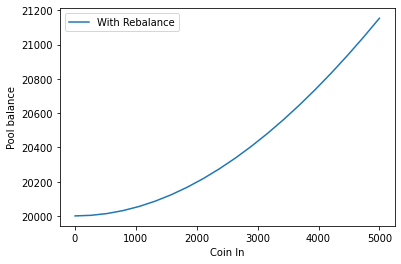

In [97]:
# Pool balance
balances = np.array([get_amm_balance(s) for s in states])
_ = plt.plot(coin_in, balances)
_ = plt.legend(['With Rebalance'])
_ = plt.xlabel('Coin In')
_ = plt.ylabel('Pool balance')

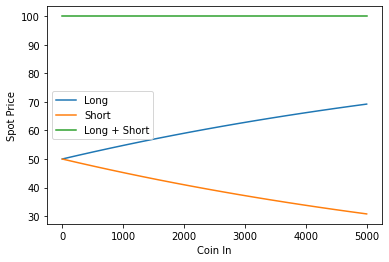

In [98]:
# Spot prices and sum
spot_prices = np.array([get_amm_spot_prices(s) for s in states])

_ = plt.plot(coin_in, spot_prices)
_ = plt.plot(coin_in, np.sum(spot_prices, axis=1))
_ = plt.legend(['Long', 'Short', 'Long + Short'])
_ = plt.xlabel('Coin In')
_ = plt.ylabel('Spot Price')

This looks good!  Sum of prices = 100, and balance has increased slightly (even without fees)

## Check swapping position token for coin

In [99]:
sell_long_no_mint_rebalance = simple_swap_to_coin(
    buy_long_no_mint_rebalance, 100-buy_long_no_mint_rebalance[1], coin_per_pair=100, rebalance=True)[0]

In [100]:
get_amm_spot_prices(sell_long_no_mint_rebalance)

[49.9999999999998, 49.9999999999998]

In [101]:
get_amm_balance(sell_long_no_mint_rebalance)

20045.9921189573

So round trip of buy L from AMM, sell L back to AMM results in the AMM gaining money.  See below for a more systematic investigation.

In [175]:
def simulate_swaps_from_coin(x_c_0, x_l_0, x_s_0, v, C, from_coin=True, c_max=1000, n_row=1, offset=0):
    initial_state = set_amm_state(x_c_0, x_l_0, x_s_0, v, C)
    
    coin_in = np.linspace(1., c_max, 20)
    states, coin_out, avg_price = zip(
        *[simple_swap_from_coin(initial_state, t, coin_per_pair=100, rebalance=True) 
          for t in coin_in])
    # No rebalancing, raw C-> L (or C->S) swap
    states_raw, tok_out_raw, avg_price_raw = zip(
        *[simple_swap_from_coin(initial_state, c, coin_per_pair=100, rebalance=False) for c in coin_in])
    
    if n_row == 1:
        _ = plt.figure(figsize=(10,4))
    # Pool balance

    balances = np.array([get_amm_balance(s) for s in states])
    balances_raw = np.array([get_amm_balance(s) for s in states_raw])
    
    _ = plt.subplot(n_row,2,1 + 2*offset)
    _ = plt.plot(coin_in, balances)
#     _ = plt.plot(coin_in, balances_raw, linestyle='--')
    _ = plt.legend(['With Rebalance', 
#                     'No Rebalance'
                   ])
    _ = plt.title(f'Spot Price = {v}')
    _ = plt.xlabel('Coin In')
    _ = plt.ylabel('Pool balance')
    
    _ = plt.subplot(n_row,2,2 + 2*offset)
    spot_prices = np.array([get_amm_spot_prices(s) for s in states])
    _ = plt.plot(coin_in, spot_prices)
    _ = plt.plot(coin_in, np.sum(spot_prices, axis=1))
    _ = plt.plot(coin_in, avg_price)
    _ = plt.legend(['Long', 'Short', 'Long + Short', 'Average Price'])
    _ = plt.xlabel('Coin In')
    _ = plt.ylabel('Spot Price')

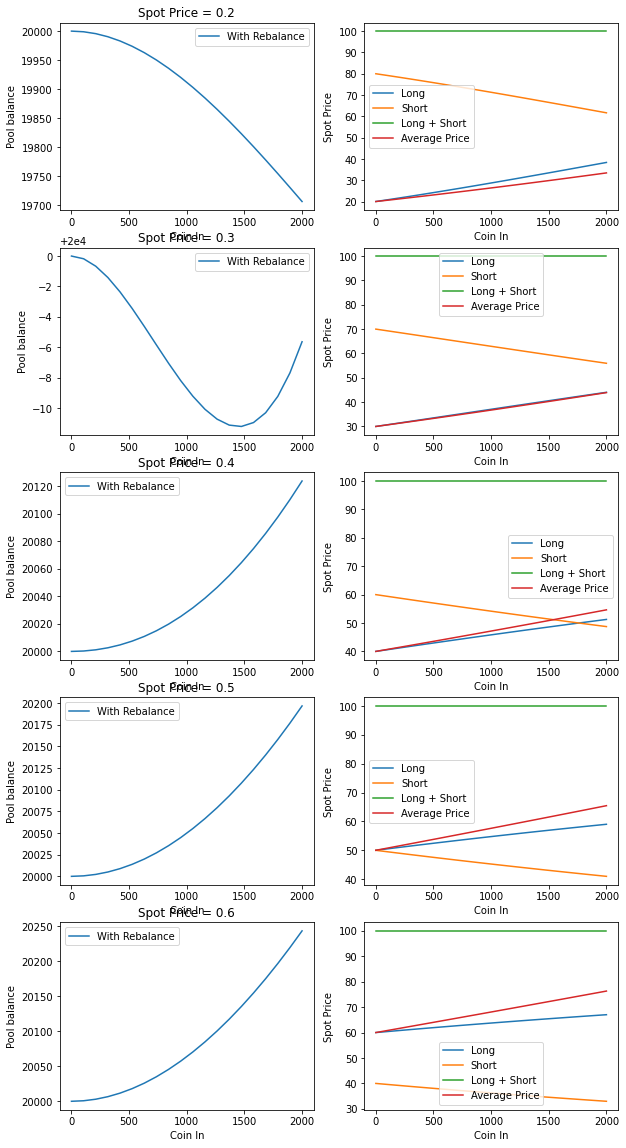

In [177]:
asset_spots = [0.2, 0.3, 0.4, 0.5, 0.6]
n_spots = len(asset_spots)
f = plt.figure(figsize=(10, 4*n_spots))
for i, spot in enumerate(asset_spots):
    simulate_swaps_from_coin(10000, 100, 100, spot, 100, c_max=2000, n_row=n_spots, offset=i)
f.savefig('amm_spot_prices.png')

In [102]:
initial_state = set_amm_state(10000, 100, 100, 0.5, 100)
tok_in = np.linspace(1., 50., 20)
states, coin_out, avg_price = zip(
    *[simple_swap_to_coin(initial_state, t, coin_per_pair=100, rebalance=True) 
      for t in tok_in])

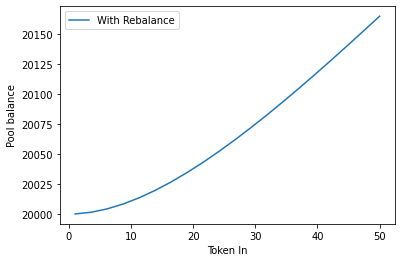

In [103]:
# Pool balance
balances = np.array([get_amm_balance(s) for s in states])
_ = plt.plot(tok_in, balances)
_ = plt.legend(['With Rebalance'])
_ = plt.xlabel('Token In')
_ = plt.ylabel('Pool balance')

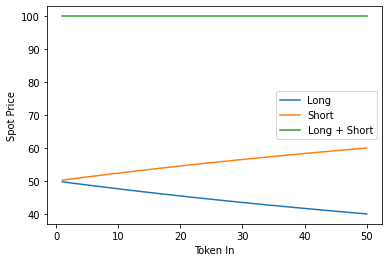

In [104]:
spot_prices = np.array([get_amm_spot_prices(s) for s in states])

_ = plt.plot(tok_in, spot_prices)
_ = plt.plot(tok_in, np.sum(spot_prices, axis=1))
_ = plt.legend(['Long', 'Short', 'Long + Short'])
_ = plt.xlabel('Token In')
_ = plt.ylabel('Spot Price')